# A Developer's Guide to the AIOS Metrics System

Welcome to this guide on the OpenOS/AIGr.id Metrics System. This notebook serves as a standalone tutorial that walks you through every step of monitoring and interpreting metrics for your AIOS Blocks. We will explore how to access live metrics, understand their structure, and leverage them for monitoring, debugging, and autoscaling.

## The AIOS Metrics System: A Brief Overview

The AIOS Metrics System is a crucial component of the AIOS ecosystem, providing real-time insights into the health, performance, and status of all running Blocks. It is designed to be a comprehensive, scalable, and extensible monitoring solution that enables developers to:

- **Monitor Block Health**: Keep track of uptime, resource utilization (CPU, GPU, memory), and other key health indicators.
- **Analyze Performance**: Measure inference latency, throughput (tokens per second), and other performance-related metrics.
- **Debug Issues**: Identify bottlenecks, errors, and anomalies by inspecting detailed metrics from each instance.
- **Drive Autoscaling**: Use metrics to define and trigger autoscaling policies, ensuring that your applications can handle varying loads efficiently.

This guide will cover the essential aspects of the Metrics System, demonstrating how to query metrics, interpret the results, and use them to manage your Blocks effectively.


## Metrics Tutorial Overview

In this guide, we will cover the following steps in detail:

1. **Accessing Block Metrics**: We will use `curl` to fetch live metrics from a running Block.
2. **Understanding the Metrics Structure**: We will break down the JSON response to understand the different types of metrics available.
3. **Interpreting Key Metrics**: We will explore the meaning and significance of important metrics, such as latency, throughput, and resource utilization.
4. **Visualizing Metrics**: We will use Python libraries to plot and visualize metrics data, making it easier to identify trends and patterns.
5. **Custom Metrics**: We will briefly touch upon how to implement and expose custom metrics from your own Blocks.

Let's get started!


## 1. Accessing Block Metrics

The primary way to access metrics for a running Block is through the Metrics API, which exposes a simple HTTP endpoint. You can use a tool like `curl` to send a GET request to this endpoint and retrieve the latest metrics data in JSON format.

The Metrics API endpoint is typically structured as follows:

`http://<metrics-service-ip>:<port>/block/<block-id>`

For this tutorial, we will use the following live metrics URL for the `gemma3-27b-block`:

`http://MANAGEMENTMASTER:30201/block/gemma3-27b-block`

Let's use `curl` to fetch the metrics for this Block.


In [1]:
import requests
import json

# Define the metrics URL
metrics_url = "http://MANAGEMENTMASTER:30201/block/gemma3-27b-block"

# Fetch the metrics data
try:
    response = requests.get(metrics_url)
    response.raise_for_status()  # Raise an exception for bad status codes
    metrics_data = response.json()
    
    # Pretty-print the JSON response
    print(json.dumps(metrics_data, indent=2))
    
except requests.exceptions.RequestException as e:
    print(f"Error fetching metrics: {e}")



{
  "data": [
    {
      "blockId": "gemma3-27b-block",
      "instances": [
        {
          "blockId": "gemma3-27b-block",
          "instanceId": "executor",
          "latency": {
            "latency": 0.00011301040649414062
          },
          "nodeKey": "executor__gemma3-27b-block",
          "tasks_processed": {
            "tasks_processed_created": 1753467161.254785,
            "tasks_processed_total": 44.0
          },
          "type": "app",
          "uptime": 996592.7238399982,
          "uptime_hours": 276.8313121777773,
          "uptime_minutes": 16609.878730666638
        },
        {
          "blockId": "gemma3-27b-block",
          "end_to_end_count_total": 94.0,
          "end_to_end_fps": 0.08011819193720228,
          "end_to_end_latency": 12.481559753417969,
          "fps": {
            "average_15m": 0,
            "average_1m": 0,
            "average_5m": 0,
            "current": 0
          },
          "hardware": {
            "cpu": {
       

## 2. Understanding the Metrics Structure

The metrics data is returned as a JSON object with a well-defined structure. Let's break down the key components of the response:

- **`data`**: The root object containing an array of Block metrics.
- **`blockId`**: The unique identifier for the Block.
- **`instances`**: An array of metric objects, one for each running instance of the Block. This includes the main `executor` and each of the worker instances (e.g., `in-vkkv`).

Each instance object contains a rich set of metrics, which can be broadly categorized as follows:

- **System Metrics**: Basic health and status information, such as `uptime`, `uptime_hours`, and `uptime_minutes`.
- **Hardware Metrics**: Resource utilization data for the underlying hardware, including `cpu`, `gpus`, and `memory`.
- **LLM-Specific Metrics**: A detailed set of metrics related to the performance of the Language Model, such as `llm_tokens_per_second`, `llm_time_to_first_token_seconds_sum`, and `llm_prompt_tokens_total`.
- **Rolling Averages**: Many metrics are also available as rolling averages over different time periods (e.g., `average_1m`, `average_5m`, `average_15m`), which are useful for smoothing out short-term fluctuations and identifying longer-term trends.


## 3. Interpreting Key Metrics

Let's take a closer look at some of the most important metrics and what they tell us about the Block's performance and health:

- **`llm_tokens_per_second`**: This metric measures the throughput of the model, indicating how many tokens it can generate per second. A higher value generally means better performance.
- **`llm_time_to_first_token_seconds_sum`**: This is the total time it takes for the model to generate the first token after receiving a prompt. A lower value is desirable, as it indicates a more responsive model.
- **`llm_active_sessions`**: This metric shows the number of active inference sessions currently being handled by the instance. It's a good indicator of the instance's current load.
- **`hardware.gpus[].utilization`**: This shows the utilization of each GPU in percentage. High utilization might indicate that the model is making good use of the available hardware, but it could also be a sign of a bottleneck if it's consistently at 100%.
- **`hardware.memory.averageUtil`**: This is the average memory utilization of the instance. A high value could indicate a memory leak or that the model requires more memory than allocated.
- **`end_to_end_latency`**: This measures the total time from when a request is sent to when the final response is received. It's a crucial metric for user-facing applications where responsiveness is key.


## 4. Visualizing Metrics

While raw JSON data is useful, visualizing metrics can make it much easier to spot trends, anomalies, and patterns. In this section, we'll use Python's `matplotlib` and `pandas` libraries to create some basic plots of our metrics data.

First, let's extract the relevant data from our `metrics_data` object and load it into a pandas DataFrame.


In [4]:
!pip3 install pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 92.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 147.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 21.8 MB/s eta 0:00:00


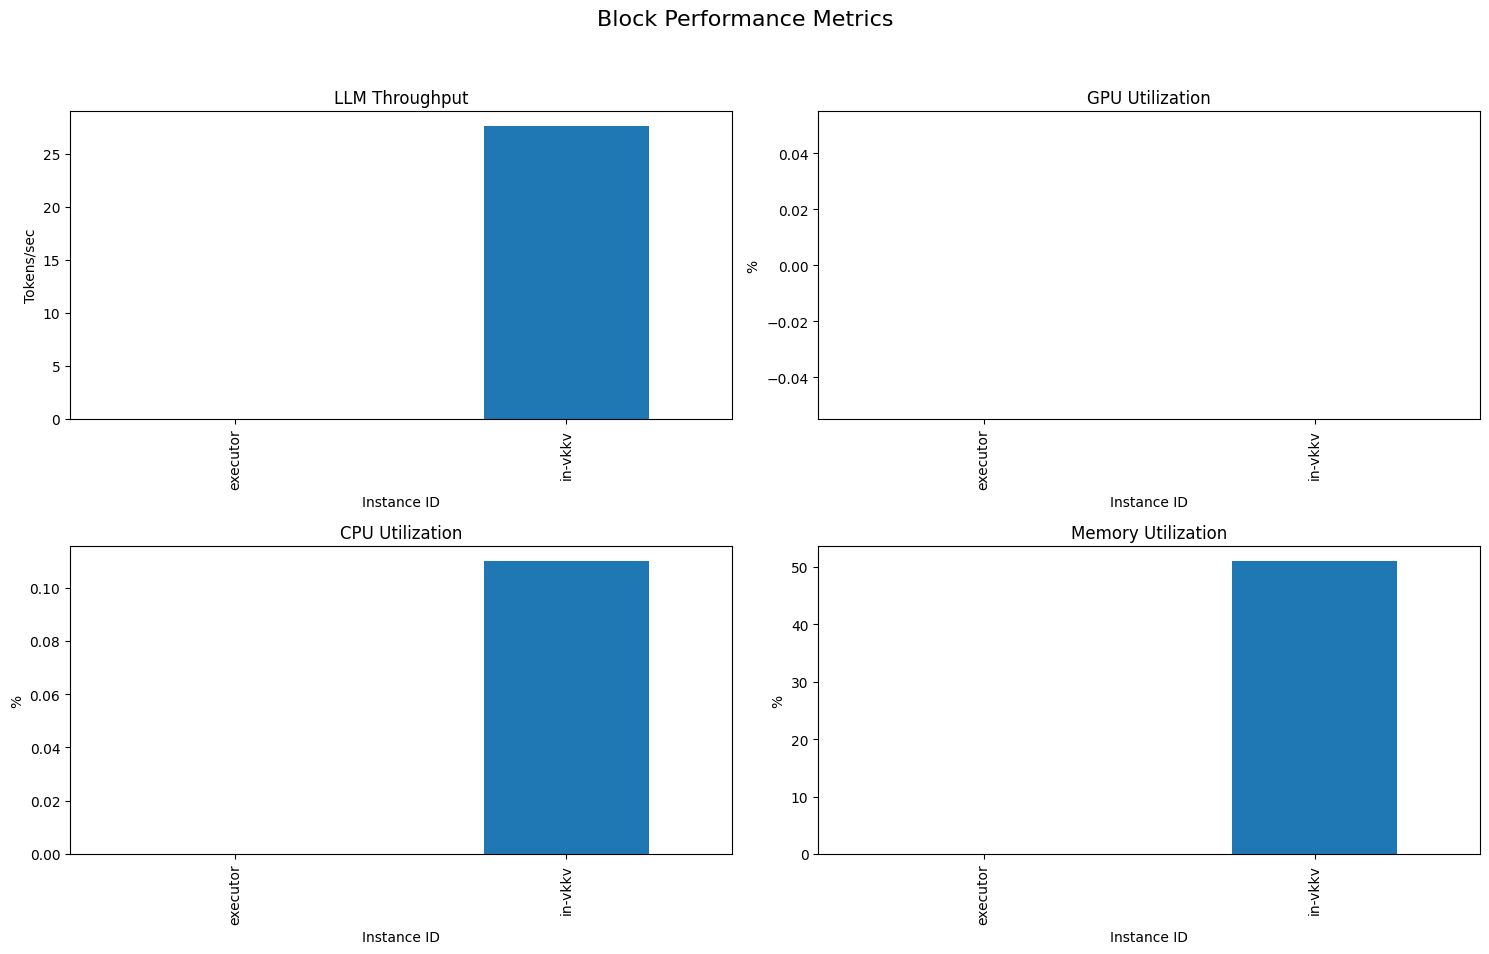

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the instance metrics from the JSON data
instance_metrics = metrics_data.get('data', [{}])[0].get('instances', [])

# Create a list to store the processed data
data_for_df = []

# Process each instance's metrics
for instance in instance_metrics:
    if instance.get('type') == 'app':  # We are interested in the application instances
        instance_id = instance.get('instanceId')
        llm_tps = instance.get('llm_tokens_per_second', 0)
        gpu_util = instance.get('hardware', {}).get('gpus', [{}])[0].get('utilization', 0)
        cpu_util = instance.get('hardware', {}).get('cpu', {}).get('percent', 0)
        mem_util = instance.get('hardware', {}).get('memory', {}).get('averageUtil', 0)
        
        data_for_df.append({
            'Instance ID': instance_id,
            'LLM Tokens/sec': llm_tps,
            'GPU Utilization (%)': gpu_util,
            'CPU Utilization (%)': cpu_util,
            'Memory Utilization (%)': mem_util * 100  # Convert to percentage
        })

# Create a pandas DataFrame
df = pd.DataFrame(data_for_df)

# Plot the data
if not df.empty:
    df.set_index('Instance ID', inplace=True)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    fig.suptitle('Block Performance Metrics', fontsize=16)
    
    df['LLM Tokens/sec'].plot(kind='bar', ax=axes[0,0], title='LLM Throughput')
    axes[0,0].set_ylabel('Tokens/sec')
    
    df['GPU Utilization (%)'].plot(kind='bar', ax=axes[0,1], title='GPU Utilization')
    axes[0,1].set_ylabel('%')
    
    df['CPU Utilization (%)'].plot(kind='bar', ax=axes[1,0], title='CPU Utilization')
    axes[1,0].set_ylabel('%')
    
    df['Memory Utilization (%)'].plot(kind='bar', ax=axes[1,1], title='Memory Utilization')
    axes[1,1].set_ylabel('%')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No application instance metrics found to plot.")


## 5. Custom Metrics & `register_custom_metrics`

The AIOS Metrics System is extensible, allowing you to define and expose your own custom metrics from your Blocks. This is particularly useful when you have application-specific metrics that you want to monitor, such as the number of active users, the cache hit rate, or the number of times a specific feature is used.

### How to Implement Custom Metrics

Implementing a custom metric is straightforward with the `aios_instance` SDK. Here is the general process:

1.  **Identify the Metric**: First, decide what application-specific value you want to monitor. For example, let's say you want to track a "user satisfaction score" that is provided after each inference.

2.  **Instrument Your Code**: In your Block's code, where the value is generated (e.g., in the function that receives user feedback), you will call the `observe_rolling()` or `observe_custom_rolling()` method on your `AIOSMetrics` instance.

3.  **Implicit Registration**: You don't need to explicitly call a `register_custom_metrics` function. The first time you call `observe_rolling("your_custom_metric_name", value)`, the metric is automatically registered within the `AIOSMetrics` object.

4.  **View the Metric**: Once your code is running, the new custom metric will automatically appear in the main metrics JSON output, complete with its `current` value and rolling averages (`average_1m`, `average_5m`, `average_15m`). From there, it can be scraped by monitoring systems or used in autoscaling policies.

The `metrics_updated.py` file provides an excellent example of how to extend the `LLMMetrics` class to add custom metrics and integrate with the native timing capabilities of the `llama_cpp` library. Let's look at a more detailed conceptual example below.

For more detailed information on how to implement custom metrics, please refer to the official documentation:

- [Custom Metrics in AIOS](https://github.com/OpenCyberspace/OpenOS.AI-Documentation/blob/main/metrics-system/metrics-system.md#custom-metrics)


## AIOS Metrics SDKs & Rolling Metrics

The AIOS platform provides a set of SDKs to simplify the process of instrumenting your applications and collecting metrics. Two key SDKs are:

- **`aios_instance` SDK**: This is a general-purpose SDK that provides the core functionality for registering and collecting metrics. It includes the `AIOSMetrics` class, which handles the registration of Prometheus metrics, the collection of hardware metrics, and the aggregation of **rolling metrics**. It is designed to be used by any type of Block, regardless of the underlying framework or application.

- **`aios_llama_cpp` SDK**: This is a specialized SDK that is designed to be used with Blocks that are based on the `llama_cpp` framework. It extends the functionality of the `aios_instance` SDK by providing a set of pre-defined metrics that are specific to LLM Blocks. It also includes the `LLMMetrics` class, which simplifies the process of collecting and reporting LLM-specific metrics, such as tokens per second, time to first token, and prompt/generation token counts.

### What are Rolling Metrics?

A **rolling metric** is a time-windowed average of a metric's values. Instead of just showing the current value, it provides averages over predefined periods (e.g., 1, 5, and 15 minutes). This is crucial for several reasons:

- **Smoothing**: It smooths out short-term spikes and dips, providing a more stable and representative view of the Block's performance over time.
- **Trend Analysis**: It helps in identifying longer-term trends. For example, a gradually increasing rolling average for latency might indicate a performance degradation issue.
- **Intelligent Autoscaling**: Autoscaling policies rely on rolling metrics to make informed decisions. Scaling based on an instantaneous value can lead to erratic behavior (e.g., scaling up for a 1-second spike and then immediately scaling down). Rolling averages ensure that scaling decisions are based on sustained load patterns.

The `aios_instance` SDK's `AIOSMetrics` class handles the complexity of calculating these rolling averages for you. When you use the `observe_rolling()` method, the SDK adds the value to a time-series data structure, and the rolling averages are automatically computed and exposed in the metrics endpoint.

The `metrics_updated.py` file provides an excellent example of how to extend the `LLMMetrics` class to add custom metrics and integrate with the native timing capabilities of the `llama_cpp` library.


In [6]:
# This is a conceptual example based on metrics_updated.py to illustrate how you might
# implement and use custom metrics. This code is not meant to be run directly in this notebook,
# but rather to serve as a reference for your own Block implementations.

import time
import logging
from collections import deque

# --- This would typically be in the aios_instance SDK ---
class RollingMetric:
    """A helper class to manage time-windowed data for rolling averages."""
    def __init__(self, window_seconds=900):
        self.window = window_seconds
        self.data = deque()

    def add(self, value):
        now = time.time()
        self.data.append((now, value))
        self._cleanup(now)

    def _cleanup(self, now):
        while self.data and self.data[0][0] < now - self.window:
            self.data.popleft()

    def average(self, window_seconds):
        now = time.time()
        self._cleanup(now)
        values = [v for t, v in self.data if t >= now - window_seconds]
        return sum(values) / len(values) if values else 0

class AIOSMetrics:
    """A simplified version of the AIOSMetrics class for demonstration."""
    def __init__(self):
        self.rolling_metrics = {}
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def observe_rolling(self, name, value):
        """Observes a value for a rolling metric. Implicitly registers the metric on first call."""
        if name not in self.rolling_metrics:
            self.logger.info(f"Implicitly registering new rolling metric: '{name}'")
            self.rolling_metrics[name] = RollingMetric()
        self.rolling_metrics[name].add(value)
        self.logger.info(f"Observed value for '{name}': {value}")

# --- This would be your custom metrics logic within your Block's code ---
class MyBlockMetrics:
    def __init__(self, metrics_backend: AIOSMetrics):
        self.metrics = metrics_backend
        self.logger = logging.getLogger(__name__)

    def log_user_feedback(self, score: float):
        """Logs a custom metric for user satisfaction."""
        # This call will create the 'user_satisfaction_score' metric if it doesn't exist,
        # and then add the new score to its time-windowed data queue.
        self.metrics.observe_rolling("user_satisfaction_score", score)

    def log_cache_hit_ratio(self, ratio: float):
        """Logs another custom metric, for example, a cache hit ratio."""
        if 0.0 <= ratio <= 1.0:
            self.metrics.observe_rolling("cache_hit_ratio", ratio)
        else:
            self.logger.warning(f"Invalid cache hit ratio: {ratio}. Must be between 0.0 and 1.0.")


# --- Example Usage (conceptual simulation) ---
print("--- Simulating Custom Metrics ---")
# 1. In your Block, you would initialize the AIOSMetrics backend.
aios_metrics_backend = AIOSMetrics()

# 2. You would then create your custom metrics handler.
my_block_metrics = MyBlockMetrics(aios_metrics_backend)

# 3. As your Block runs, it calls the logging methods.
print("\\n--- Logging user feedback scores ---")
my_block_metrics.log_user_feedback(4.5) # User gives a rating of 4.5
time.sleep(0.1) # Simulate time passing
my_block_metrics.log_user_feedback(3.0) # Another user gives a rating of 3.0
time.sleep(0.1)
my_block_metrics.log_user_feedback(5.0)

print("\\n--- Logging cache hit ratios ---")
my_block_metrics.log_cache_hit_ratio(0.85)
time.sleep(0.1)
my_block_metrics.log_cache_hit_ratio(0.92)

# 4. The AIOS Metrics System would then expose this data. Here's how to see the result:
print("\\n--- Retrieving simulated metrics ---")
satisfaction_metric = aios_metrics_backend.rolling_metrics.get("user_satisfaction_score")
if satisfaction_metric:
    # The average over the last 60 seconds (in this simulation, it includes all values)
    avg_satisfaction = satisfaction_metric.average(60)
    print(f"Average User Satisfaction (1m): {avg_satisfaction:.2f}")

cache_metric = aios_metrics_backend.rolling_metrics.get("cache_hit_ratio")
if cache_metric:
    avg_cache_ratio = cache_metric.average(60)
    print(f"Average Cache Hit Ratio (1m): {avg_cache_ratio:.2f}")

# Example of what the final JSON might contain for these custom metrics:
# "user_satisfaction_score": {
#   "current": 5.0,
#   "average_1m": 4.17,
#   ...
# },
# "cache_hit_ratio": {
#   "current": 0.92,
#   "average_1m": 0.89,
#   ...
# }


INFO:__main__:Implicitly registering new rolling metric: 'user_satisfaction_score'
INFO:__main__:Observed value for 'user_satisfaction_score': 4.5
INFO:__main__:Observed value for 'user_satisfaction_score': 3.0


--- Simulating Custom Metrics ---
\n--- Logging user feedback scores ---


INFO:__main__:Observed value for 'user_satisfaction_score': 5.0
INFO:__main__:Implicitly registering new rolling metric: 'cache_hit_ratio'
INFO:__main__:Observed value for 'cache_hit_ratio': 0.85
INFO:__main__:Observed value for 'cache_hit_ratio': 0.92


\n--- Logging cache hit ratios ---
\n--- Retrieving simulated metrics ---
Average User Satisfaction (1m): 4.17
Average Cache Hit Ratio (1m): 0.89


# Enabling Metrics During Custom Blocks Onboarding

### Step 1: Initialization in `main.py`

The process begins in the `__init__` method of the `LlamaCppChatBlock` class in `main.py`.

1.  **Get Metrics Backend**: The block receives the `context` object from the AIOS runtime. `context.metrics` is the handle to the underlying metrics backend.
2.  **Instantiate Custom Metrics Class**: It creates an instance of `LLMMetricsUpdated`, passing the `context.metrics` backend to it. This wrapper class will handle all LLM-specific metric logic.
3.  **Dependency Injection**: The newly created `metrics` object is then passed down into the `LLAMAUtils` class, which handles the actual model interactions. This is a clean way to provide the metrics capability to the parts of the code that need it.

In [ ]:
# In main.py LlamaCppChatBlock.__init__

# -------------------------- metrics hooks --------------------------
# Check if metrics are enabled in the block's settings
enable_metrics = init_settings.get("enable_metrics", True)

# Instantiate our custom metrics class with the backend from the context
self.metrics = LLMMetricsUpdated(self.context.metrics) if enable_metrics and self.context.metrics else None

# ... existing code ...

# -------------------------- llama‑cpp init -------------------------
# Pass the metrics object to the utility class via dependency injection
self.llama = LLAMAUtils(
    model_path=self.local_model_name,
    # ... other params
    metrics=self.metrics,
    model_config=copy.deepcopy(self.model_config),
    cleanup_config=copy.deepcopy(self.cleanup_config)
)

### Step 2: Defining Custom Rolling Metrics in `metrics_updated.py`

The `LLMMetricsUpdated` class is where we define the logic for our custom metrics. A key requirement for autoscaling is to have rolling averages of token inputs and outputs.

In the `log_prompt` method below, you can see how a standard metric (`llm_prompts_total`) is incremented, but more importantly, `self.metrics.observe_rolling()` is called. This is the crucial function from the AIOS SDK that creates and updates our custom rolling metric, `llm_input_tokens_per_minute_rolling`, which is essential for making intelligent autoscaling decisions.

In [ ]:
# In aios_llama_cpp/metrics_updated.py LLMMetricsUpdated.log_prompt

def log_prompt(self, prompt_token_count: int):
    """Log a prompt processing event"""
    try:
        # --- Standard Metrics ---
        # Increment counters for total prompts and total prompt tokens
        self.metrics.increment_counter("llm_prompts_total")
        counter = self.metrics.metrics.get("llm_prompt_tokens_total")
        if counter:
            counter.inc(prompt_token_count)
        
        # --- Custom Rolling Metric for Autoscaling ---
        # This is the key addition. We observe the token count, and the AIOS
        # backend automatically calculates rolling averages (1m, 5m, 15m).
        self.metrics.observe_rolling("llm_input_tokens_per_minute_rolling", prompt_token_count)

    except Exception as e:
        logger.error(f"❌ ERROR in log_prompt: {e}")

### Step 3: Instrumenting the Core Logic in `library.py`

Now that the metrics object is available in `LLAMAUtils`, we can instrument the inference code. Inside the `run_chat_inference` method, after a response has been generated, there is a check to see if `self.metrics` exists.

If it does, the code calls the various methods on our `LLMMetricsUpdated` instance (`log_prompt`, `log_response`, etc.) to record the performance data for that specific request. This ensures that every inference call is measured and contributes to the overall metrics.

In [ ]:
# In aios_llama_cpp/library.py LLAMAUtils.run_chat_inference (non-streaming part)

# ... after inference completes and response is received ...

if self.metrics:
    # Extract performance data from the response
    generated_tokens = response["usage"]["completion_tokens"]
    duration = end_time - start_time
    
    try:
        # Call the methods on our LLMMetricsUpdated instance to record the data
        self.metrics.log_prompt(prompt_tokens)
        self.metrics.log_response(generated_tokens)
        self.metrics.observe_inference_time(start_time)
        self.metrics.update_tokens_per_second(generated_tokens, duration)
        
        # This call is crucial for ensuring certain rolling averages are kept up-to-date
        self.update_rolling_metrics()

    except Exception as metrics_error:
        logger.error(f"❌ METRICS ERROR in run_chat_inference: {metrics_error}")

### Step 4: Advanced Integration - Leveraging Native Timings

A powerful feature of this integration is the ability to use highly accurate performance data directly from the `llama_cpp` engine, rather than relying on less precise Python-level timing.

1.  **Model Reference**: In `main.py`, after the model is loaded, a reference to the model object is passed to the metrics class using `self.metrics.set_model_reference(self.model)`.
2.  **Native Timings**: The `LLMMetricsUpdated` class can now call `self._model_reference._ctx.get_timings()` to get precise, low-level performance data.
3.  **Prioritized Data**: As shown below in the `observe_inference_time` method, the code first attempts to get the native timing. If it's available, it uses that for maximum accuracy; otherwise, it falls back to the manually calculated duration. This ensures the best possible data quality.

In [ ]:
# In aios_llama_cpp/metrics_updated.py LLMMetricsUpdated.observe_inference_time

def observe_inference_time(self, start_time: float):
    """
    Observe inference duration, preferring native llama_cpp timings if available.
    """
    calculated_elapsed = time.time() - start_time
    
    # Default to the calculated duration
    final_elapsed = calculated_elapsed
    
    # Try to get the more accurate native timings from the llama_cpp engine
    native_timings = self._get_native_timings()
    
    if native_timings and self._use_native_timings:
        # If available, use the native evaluation time (in milliseconds)
        native_elapsed = native_timings['eval'].get('t_eval_ms', 0) / 1000.0
        if native_elapsed > 0:
            final_elapsed = native_elapsed  # Override with the more accurate value
            logger.info(f"🔧 Using native inference timing: {final_elapsed:.4f}s")
    
    # Observe the final value (either native or calculated) for the histogram and rolling average
    self.metrics.observe_histogram("llm_inference_duration_seconds", final_elapsed)
    self.metrics.observe_rolling("llm_inference_duration_rolling", final_elapsed)

### Integration Summary

This example illustrates a clean, modular, and powerful pattern for integrating metrics into an AIOS Block:
-   **Centralized Initialization**: The main block class (`main.py`) is responsible for setting up metrics.
-   **Dedicated Metrics Class**: A separate class (`metrics_updated.py`) encapsulates all metrics-related logic, making it easy to manage and extend.
-   **Decoupled Instrumentation**: The core application logic (`library.py`) simply calls the methods of the metrics class without needing to know the implementation details.
-   **Extensibility**: This pattern makes it simple to add new custom metrics (like `user_satisfaction_score` or `cache_hit_ratio`) by just adding a new method to `LLMMetricsUpdated` and calling it from `LLAMAUtils`.

By following this pattern, you can build robust, observable, and scalable AIOS Blocks.


## Conclusion

In this tutorial, we have explored the AIOS Metrics System, learning how to access, interpret, and visualize metrics for a running Block. We have seen how the Metrics System provides a comprehensive set of tools for monitoring the health, performance, and status of your AI applications.

By leveraging the insights provided by the Metrics System, you can ensure that your applications are running smoothly, identify and resolve issues quickly, and make informed decisions about how to scale and optimize your resources.

We encourage you to explore the Metrics System further and to integrate it into your own AIOS development workflow.
